In [105]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io as skio
import scipy
import time
import os
from skimage.metrics import structural_similarity as ssim
from jpeg_class import JPEG
#import jpeg_class
#import importlib
#importlib.reload(jpeg_class)


# JPEG 

Image shape: (352, 800, 3)
Image data type: uint8
Theoretical uncompressed image size: 0.81 MB


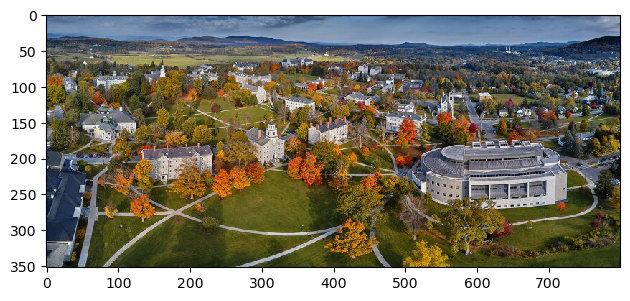

In [11]:
midd = skio.imread("midd.jpeg")
midd = midd[1:,  ] # should standardize this to blocks
skio.imshow(midd)

print(f'Image shape: {midd.shape}')
print(f'Image data type: {midd.dtype}')
print(f'Theoretical uncompressed image size: {np.round(np.prod(np.asarray(midd.shape)) / (1024 ** 2),2)} MB')

Image shape: (2992, 2016, 3)
Image data type: uint8
Theoretical uncompressed image size: 17.26 MB


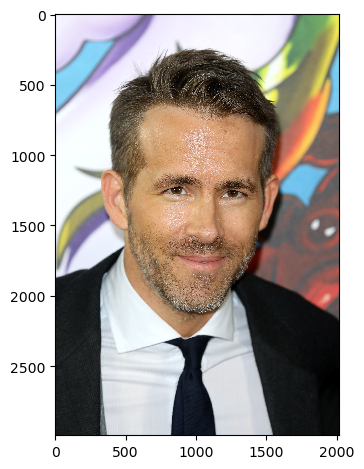

In [3]:
ryan = skio.imread("ryan.jpg")
ryan = ryan[8:,18:  ] # should standardize this to blocks
skio.imshow(ryan)

print(f'Image shape: {ryan.shape}')
print(f'Image data type: {ryan.dtype}')
print(f'Theoretical uncompressed image size: {np.round(np.prod(np.asarray(ryan.shape)) / (1024 ** 2),2)} MB')

Image shape: (4000, 6016, 3)
Image data type: uint8
Theoretical uncompressed image size: 68.85 MB


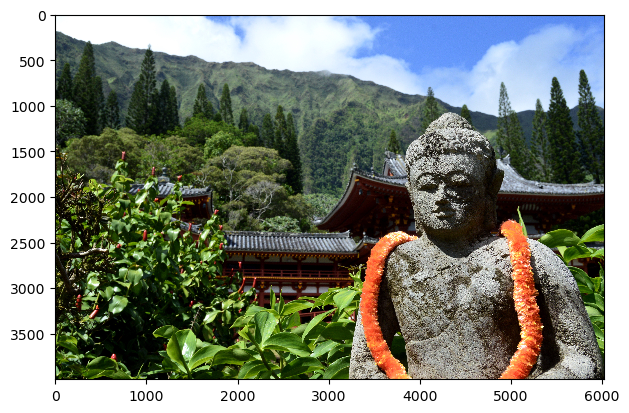

In [13]:
monk = skio.imread("monk.jpg")
skio.imshow(monk)

print(f'Image shape: {monk.shape}')
print(f'Image data type: {monk.dtype}')
print(f'Theoretical uncompressed image size: {np.round(np.prod(np.asarray(monk.shape)) / (1024 ** 2),2)} MB')

## Sample Compression

Here we save to disk, load that filepath, decode.

Original: 736.20 KB
Time Taken: 0.3s
Compressed: 189.71 KB


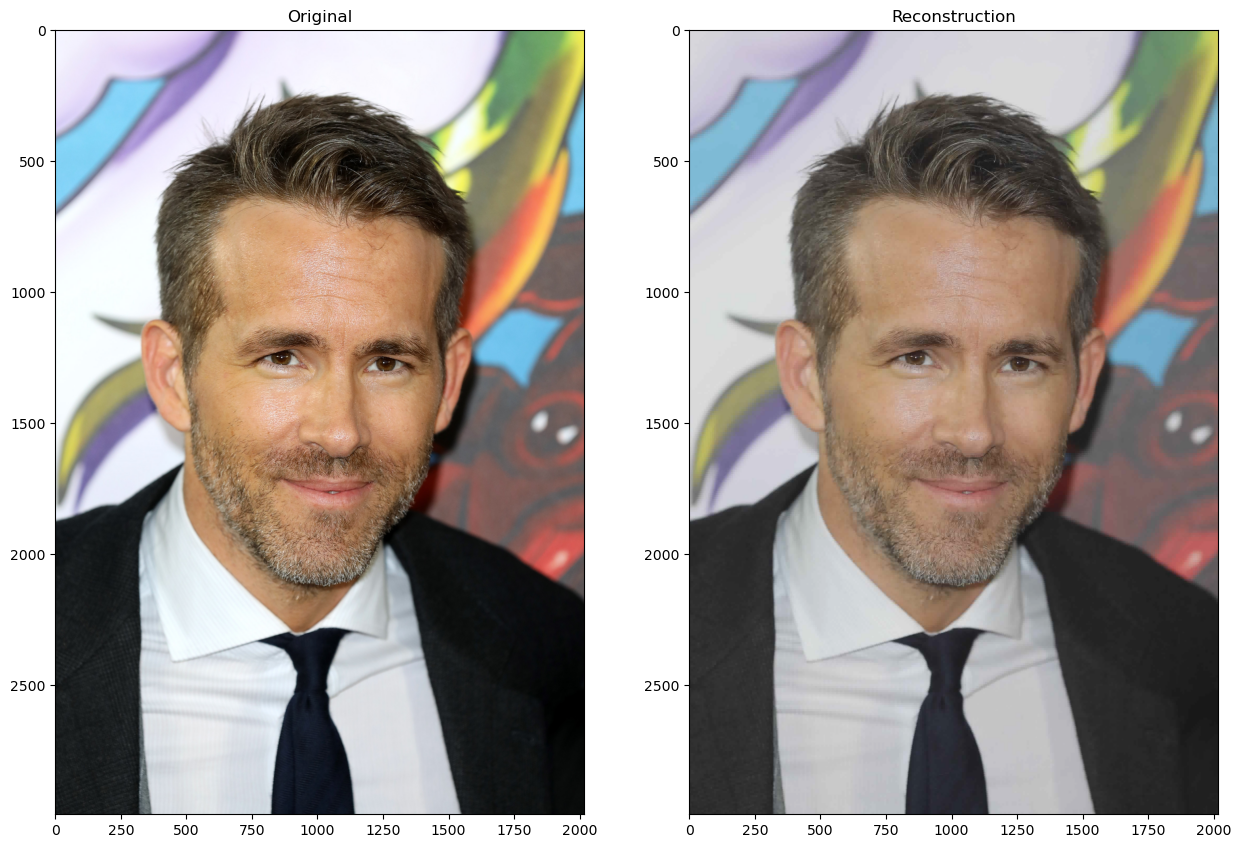

In [127]:
size = os.path.getsize("ryan.jpg")

print(f"Original: {size / 1024:.2f} KB")
current = time.time()
jpg = JPEG(ryan, downsample_ratio="4:2:0", q = 90, dynamic = False)
jpg.encode()
jpg.save_image("1.zst")

size = os.path.getsize("1.zst")
print(f"Time Taken: {np.round(time.time() - current, 1)}s")
print(f"Compressed: {size / 1024:.2f} KB")

jpg2 = JPEG.load_image("1.zst")
jpg2.decode()
jpg2.compare_image(ryan)

and once we do dynamic quantization can compare the decline in slope in ssim

there is actually decrease in filesize at high values of quality with dynamic compression

can just do all 6 lines on the same plot, compare the algorithms.
shouldn't be too bad visually

## Fixed Quantization: Plotting Quality vs File Size

Here I use 3 sample images and see how the quality affects the compressed file size.

In [15]:
def get_filesize(img, **kwargs):
    jpg = JPEG(img, **kwargs)
    jpg.encode()
    jpg.save_image("temp.zst")
    size = os.path.getsize("temp.zst")
    return size

In [16]:
def quality_vs_filesize(img, qualities, **kwargs):
    filesizes = []
    for quality in qualities:
        kwargs['q'] = quality
        filesize = get_filesize(img, **kwargs)
        filesizes.append(filesize)
    return np.asarray(filesizes)

In [17]:
qualities = range(100,0,-5)
monk_filesizes = quality_vs_filesize(monk, qualities, downsample_ratio = "4:2:0")
midd_filesizes = quality_vs_filesize(midd, qualities, downsample_ratio = "4:2:0")
ryan_filesizes = quality_vs_filesize(ryan, qualities, downsample_ratio = "4:2:0")

Text(0.5, 1.0, 'Quality vs. Filesize for Three Sample Images')

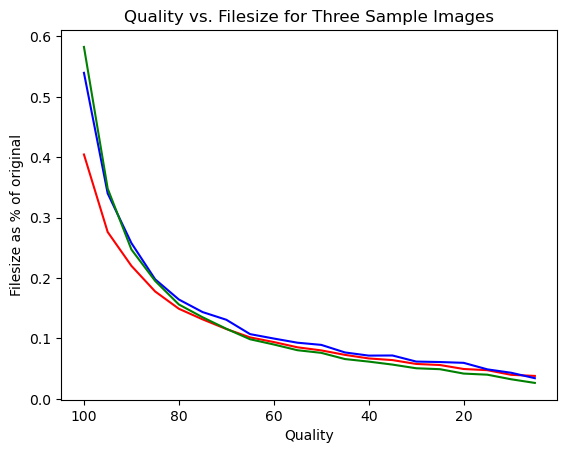

In [57]:
monk_size = os.path.getsize("monk.jpg")
midd_size = os.path.getsize("midd.jpeg")
ryan_size = os.path.getsize("ryan.jpg")

plt.plot(qualities, monk_filesizes / monk_size, color = "red")
plt.plot(qualities, ryan_filesizes / ryan_size, color = "blue")
plt.plot(qualities, midd_filesizes / midd_size, color = "green")

plt.gca().invert_xaxis()

plt.xlabel('Quality')
plt.ylabel('Filesize as % of original')
plt.title('Quality vs. Filesize for Three Sample Images')

# Fixed Quantization: Plotting Quality vs SSIM

In [19]:
def get_ssim(img, **kwargs):
    jpg = JPEG(img, **kwargs)
    jpg.encode(max_step = 5) # everything after this is lossless so won't bother
    jpg.decode(from_step = 5)
    similarity = ssim(img, jpg.img_array, channel_axis = 2)
    return similarity

In [20]:
def quality_vs_ssim(img, qualities, **kwargs):
    ssims = []
    for quality in qualities:
        kwargs['q'] = quality
        local_ssim = get_ssim(img, **kwargs)
        ssims.append(local_ssim)
    return np.asarray(ssims)

In [21]:
qualities = range(100,0,-5)
monk_ssim = quality_vs_ssim(monk, qualities, downsample_ratio = "4:2:0")
midd_ssim = quality_vs_ssim(midd, qualities, downsample_ratio = "4:2:0")
ryan_ssim = quality_vs_ssim(ryan, qualities, downsample_ratio = "4:2:0")

Text(0.5, 1.0, 'Quality vs. SSIM for Three Sample Images')

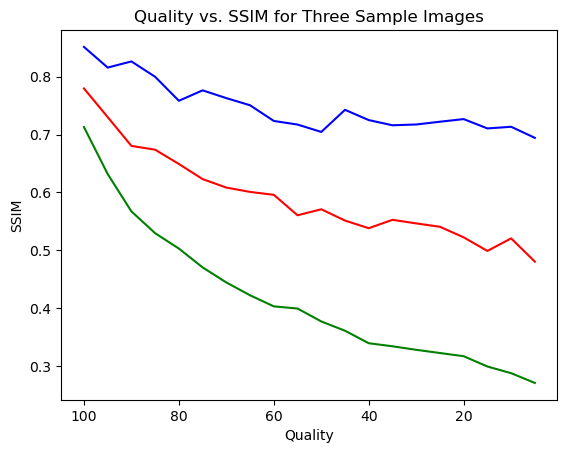

In [56]:
plt.plot(qualities, monk_ssim, color = "red")
plt.plot(qualities, ryan_ssim, color = "blue")
plt.plot(qualities, midd_ssim, color = "green")

plt.gca().invert_xaxis()

plt.xlabel('Quality')
plt.ylabel('SSIM')
plt.title('Quality vs. SSIM for Three Sample Images')

# Fixed Quantization: Filesize vs SSIM

In [128]:
plt.plot(monk_filesizes / monk_size, monk_ssim, color = "red")
plt.plot(ryan_filesizes / ryan_size, ryan_ssim, color = "blue")
plt.plot(midd_filesizes / midd_size, midd_ssim, color = "green")

plt.xlabel('Filesize as % of Original')
plt.ylabel('SSIM')
plt.title('Filesize vs. Quality for Three Sample Images')

NameError: name 'monk_filesizes' is not defined

# Dynamic Quantization: Filesize vs SSIM

# Example Gradient of Qualities

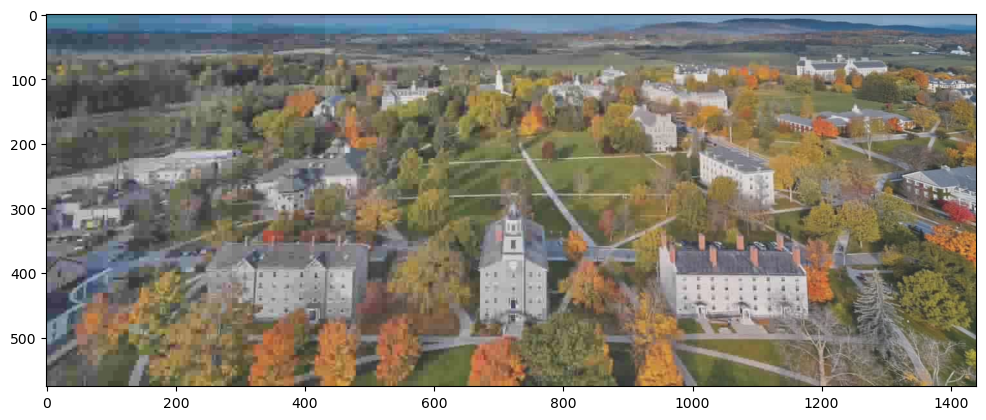

In [58]:
midd2 = skio.imread("midd2.jpeg")

gradient_img = np.zeros_like(midd2)

for i in range(1,11):
    jpg = JPEG(midd2, q = 50 + i * 5, downsample_ratio = "4:2:0") # only going from 50 to 100
    jpg.encode()
    jpg.decode()
    gradient_img[:, ((i - 1) * midd2.shape[1] // 10): i * midd2.shape[1] // 10, :] = \
        jpg.img_array[:, ((i - 1) * midd2.shape[1] // 10): i * midd2.shape[1] // 10, :]


plt.figure(figsize=(12, 8))
plt.imshow(gradient_img)